# Comparing FreeSurfer, FastSurfer and atlas-based

In [1]:
import numpy as np
import pandas as pd
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import ptitprince as pt

import glob
import re
import os

sns.set_theme()
sns.set_context("paper")

## UKBB pipeline IDPs

In [2]:
# some useful dictonaries and lists
vendor_dict = {"TRI": "Siemens", "PRI": "Siemens", "ING": "Philips", "ACH": "Philips", "GEM": "GE"}

scanner_dict = {"NOT1ACH": "Philips Achieva",
                "NOT2ING": "Philips Ingenia", 
                "NOT3GEM": "GE MR750", 
                "OXF1PRI": "Siemens Prisma 32",
                "OXF2PRI": "Siemens Prisma 64",
                "OXF3TRI": "Siemens Trio"}

scanner_code_dict = {"NOT1ACH": "Ach",
                        "NOT2ING": "Ing", 
                        "NOT3GEM": "750", 
                        "OXF1PRI": "Pri32",
                        "OXF2PRI": "Pri64",
                        "OXF3TRI": "Trio"}

fmriopt_dict = {"task-rest_acq-multiband4_bold": "Ing: MB4", # we want to keep the MB4 data
                "task-rest_acq-multiband6_bold": "Ing: MB6", 
                "task-rest_acq-resopt1_bold": "GE: 2.4iso",
                "task-rest_acq-resopt2_bold": "GE: 3.3iso", # we want to keep the 3.3mm data
                "task-rest_acq-resopt3_bold": "GE: 2.2x2.3x3.3"}

fmriopt_key_dict = {"task-rest_bold": "standard",
                    "task-rest_acq-multiband4_bold": "standard",
                    "task-rest_acq-multiband6_bold": "non-standard", 
                    "task-rest_acq-resopt1_bold": "non-standard",
                    "task-rest_acq-resopt2_bold": "standard", 
                    "task-rest_acq-resopt3_bold": "non-standard"} # standard are used for analyses

# the session info headers
fmri_info_hdrs = ['fmriopt_key', 'fmriopt', 'fmri_modality', 'fmri_spacing_tr', 
                   'fmri_spacing_x', 'fmri_spacing_y', 'fmri_spacing_z', 'fmri_size_t', 'fmri_scan_time']

basic_info_hdrs = ['session', 'scanner_name', 'vendor', 'scanner_code', 
#                    'denoised',
             'scanner_type', 'scanner_typeloc', 'scan_session_num', 'scan_session', 'subject']

info_hdrs = basic_info_hdrs + fmri_info_hdrs

##### IQM headers
# the T1w IQMs
anat_iqm_hdrs = ['T1w_fwhm_avg', 'T1w_fwhm_x', 'T1w_fwhm_y', 'T1w_fwhm_z', 
               'T1w_snr_total', 'T1w_snr_gm', 'T1w_snr_wm', 'T1w_snr_csf', 
               'T1w_snrd_total', 'T1w_snrd_gm', 'T1w_snrd_wm', 'T1w_snrd_csf', 
#                'T1w_effective_snr_total', 'T1w_effective_snr_gm', 'T1w_effective_snr_wm', 'T1w_effective_snr_csf', 
#                'T1w_effective_snrd_total', 'T1w_effective_snrd_gm', 'T1w_effective_snrd_wm', 'T1w_effective_snrd_csf', 
               'T1w_qi_1', 'T1w_cnr', 'T1w_cjv', 'T1w_efc']

# the fMRI IQMs (first 3 are UKBB measures)
fmri_iqm_hdrs = ['rfMRI_head_motion', 'rfMRI_TSNR', 'rfMRI_cleaned_TSNR', 'fmri_fwhm_avg',
                'fmri_fwhm_x', 'fmri_fwhm_y', 'fmri_fwhm_z', 
#                  'fmri_snr', 'fmri_tsnr', 
                 'fmri_effective_snr', 'fmri_effective_tsnr', 'fmri_etSNR/Pri',
                 'fmri_efc', 'fmri_fd_mean', 'fmri_fd_perc', 'fmri_aor', 'fmri_aqi']# , 'fmri_fber']

# the dMRI IQMs - excluding the higher shell QC measures (as GE is single-shell)
dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
       'dMRI_qc_outliers_b_1',
       'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       'dMRI_qc_outliers_tot']

all_dmri_iqm_hdrs = ['dMRI_eddy_outlier', 'dMRI_qc_cnr_avg_1', 'dMRI_qc_cnr_avg_2',
       'dMRI_qc_cnr_avg_3', 'dMRI_qc_cnr_std_1', 'dMRI_qc_cnr_std_2',
       'dMRI_qc_cnr_std_3', 'dMRI_qc_outliers_b_1', 'dMRI_qc_outliers_b_2',
       'dMRI_qc_outliers_pe_1', 'dMRI_qc_mot_abs', 'dMRI_qc_mot_rel',
       'dMRI_qc_outliers_tot']

# all IQM headers
iqm_hdrs = anat_iqm_hdrs + fmri_iqm_hdrs + dmri_iqm_hdrs



In [3]:
def get_measure_type(measure_names, IDP=True):
    measure_type = []
    if IDP == True:
        for l in measure_names:
            if 'T1_SIENAX' in l:
                measure_type = measure_type + ['FSL Tissue volumes']
            elif 'T1_GM_parcellation' in l:
                measure_type = measure_type + ['FSL GM volumes']
            elif 'T1_FIRST' in l:
                measure_type = measure_type + ['FSL Subcortical volumes']
            elif 'freesurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FreeSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (DK)']
                elif 'a2009s' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical surface area (Destrieux)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical volume (Destrieux)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical thickness (Destrieux)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FreeSurfer Cortical curvature (Destrieux)']
            elif 'fastsurfer' in l:
                if 'aseg' in l:
                    measure_type = measure_type + ['FastSurfer Subcortical volumes']
                elif 'DK' in l:
                    if 'SurfArea' in l:
                        measure_type = measure_type + ['FastSurfer Cortical surface area (DK)']
                    elif 'GrayVol' in l:
                        measure_type = measure_type + ['FastSurfer Cortical volume (DK)'] 
                    elif 'ThickAvg' in l:
                        measure_type = measure_type + ['FastSurfer Cortical thickness (DK)']
                    elif 'MeanCurv' in l:
                        measure_type = measure_type + ['FastSurfer Cortical curvature (DK)']
                
    measure_type = [l.replace('_', ' ') for l in measure_type]
    measure_type = [l.replace('v1', ' ') for l in measure_type]
    return measure_type

def get_stats(df):
    mn = df.mean(axis=0).abs()
    std = df.std(axis=0).abs()
    med = df.median(axis=0).abs()
    mad = df.mad(axis=0)
    mad_med = mad/med
    cv = std/mn
    return mn, med, mad, cv, mad_med

def get_null_corr(figobj, nsamp1=10, nsamp2=6, niter=1000):
    nullcorr = np.zeros((niter,))
    for i in range(0, niter):
        nullcorr[i] = sc.stats.spearmanr(np.random.choice(range(nsamp1), nsamp1, replace=False), 
                           np.random.choice(range(nsamp1), nsamp1, replace=False), axis=1)[0]
        
    null_iqr = np.percentile(nullcorr, [25, 75])
    
    if hasattr(figobj, 'get_xlim'):
        xlims = figobj.get_xlim()[0], figobj.get_xlim()[1]
        ylims = figobj.get_ylim()[0], figobj.get_ylim()[1]
        figobj.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
        figobj.set_xlim(xlims[0], xlims[1])
        figobj.set_ylim(0, ylims[1])
    else:
        ylims = figobj.axes[0][0].get_ylim()[0], figobj.axes[0][0].get_ylim()[1]
        
        for ax in figobj.axes[0]:
            xlims = ax.get_xlim()[0], ax.get_xlim()[1]
            ax.fill_between([xlims[0]-1, xlims[1]+1], null_iqr[0], null_iqr[1], color='red', alpha=0.2)
            ax.set_xlim(xlims[0], xlims[1])
            
        g.set(ylim=(ylims[0], ylims[1]))


## Build main dataframe

#### Load UKBB pipeline data

In [4]:
studydir = '/Users/shaunwarrington/OneDrive - The University of Nottingham (1)/Deliverables/Papers/NHarmony'
fig_out = f'{studydir}/pyfigs'

# Load IDP headers
hdrs = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
hdrs = np.concatenate([['session'], hdrs])
hdrs = [x for x in hdrs if 'mist' not in x] # not using MIST

# Load subject-wise IDPs
idp_files = glob.glob(f'{studydir}/data/IDPs/*[!denoise].txt')
df = [pd.read_csv(f, sep=" ", index_col=None, header=None) for f in idp_files]
df = pd.concat(df, ignore_index=True)

df.columns = hdrs
df = df[df.columns.drop(list(df.filter(regex='tfMRI')))] # drop task-fMRI IDPs

print(f'{df.shape[0]} sessions')
print('The raw measures:')
df.head(5)

99 sessions
The raw measures:


,session,1_l_align_to_std_diff,1_nl_align_to_std_diff,1_nl_align_to_std_warp,1_inverse_SNR,1_inverse_CNR,2_FLAIR_align_to_T1,MRI_align_to_T1,WI_align_to_T1,fMRI_align_to_T1,...,T1_GM_parcellation_L_VIIIb_Cerebellum_vol,T1_GM_parcellation_Vermis_VIIIb_Cerebellum_vol,T1_GM_parcellation_R_VIIIb_Cerebellum_vol,T1_GM_parcellation_L_IX_Cerebellum_vol,T1_GM_parcellation_Vermis_IX_Cerebellum_vol,T1_GM_parcellation_R_IX_Cerebellum_vol,T1_GM_parcellation_L_X_Cerebellum_vol,T1_GM_parcellation_Vermis_X_Cerebellum_vol,T1_GM_parcellation_R_X_Cerebellum_vol,T2_FLAIR_WMH_volume
0,03997_NOT2ING001,0.709639,0.565298,0.068010,0.023000,0.048365,0.417115,0.817849,0.398544,0.896350,...,2109.992313,329.589582,2049.580686,1162.600140,208.419435,1462.600181,578.780475,222.489944,442.430170,1293
1,14229_NOT2ING001,0.709498,0.558609,0.074845,0.023515,0.050278,0.332084,0.655481,0.396900,0.954145,...,2143.709358,353.850084,2574.299187,1158.141840,299.850408,1511.128623,575.468728,228.350319,631.039500,2118
2,10975_OXF1PRI001,0.671640,0.532363,0.060674,0.014329,0.029774,0.506442,0.606848,0.408396,0.862284,...,2109.548870,282.620293,2201.957280,1493.439980,277.000116,1541.828000,463.729077,230.000078,399.809908,89
3,13192_OXF2PRI001,0.751898,0.578664,0.066386,0.014678,0.031013,0.467204,0.739697,0.509247,0.966793,...,2340.322330,324.540300,1955.638035,1420.989965,309.450327,1752.868617,464.880968,175.439902,432.559840,594
4,03286_OXF2PRI001,0.779914,0.612624,0.075811,0.015209,0.034127,0.489486,0.624702,0.491941,0.867948,...,2426.239281,318.269952,2279.822940,1753.326639,419.030611,1997.429920,563.281340,239.979695,533.270100,4638


#### Get the header descriptions

In [5]:
hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])
hdr_descriptions["hdr"] = np.loadtxt(f'{studydir}/data/headers.txt', 'str')
                                     
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("tfMRI")==False]
hdr_descriptions = hdr_descriptions[hdr_descriptions["hdr"].str.contains("mist")==False]

def hdr_desc(hdr):
    try:
        desc = hdr_descriptions.loc[hdr_descriptions.hdr == hdr, 'desc'].values[0]
    except:
        desc = hdr
    return desc


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/1054213702.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hdr_descriptions = pd.read_csv(f'{studydir}/data/hdr_descriptions.txt', sep="\r\t", names=['desc'])


#### Load FreeSurfer IDPs - aseg lh.aparc.DKTatlas rh.aparc.DKTatlas lh.aparc.a2009s rh.aparc.a2009s

In [6]:
###### aseg
measure_name = 'aseg'
idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
tempdf = pd.DataFrame()
for f in idp_files:
    d = pd.read_csv(f, sep="\s+", index_col=None)
    d['session'] = os.path.basename(f)
    tempdf = pd.concat((tempdf, d), ignore_index=True)
    
# get volumes
val_cols = ['Volume_mm3']
tempdf = tempdf[['StructName', 'session'] + val_cols]
tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
tempdf.reset_index(inplace=True, drop=False)

# drop WM measures
tempdf = tempdf[tempdf.columns.drop(list(tempdf.filter(regex='WM-')))]

# add prefix
tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)

# build FreeSurfer dataframe
df_fs = tempdf.copy()

###### aparc cortical atlases
for measure_name in ['lh.aparc.DKTatlas', 'rh.aparc.DKTatlas', 'lh.aparc.a2009s', 'rh.aparc.a2009s']:
    idp_files = glob.glob(f'{studydir}/data/freesurfer_stats/{measure_name}/*')
    tempdf = pd.DataFrame()
    for f in idp_files:
        d = pd.read_csv(f, sep="\s+", index_col=None)
        d['session'] = os.path.basename(f)
        tempdf = pd.concat((tempdf, d), ignore_index=True)

    # get StructName, SurfArea, GrayVol, ThickAvg, MeanCurv
    val_cols = ['SurfArea', 'GrayVol', 'ThickAvg', 'MeanCurv']
    tempdf = tempdf[['StructName', 'session'] + val_cols]
    tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
    tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
    tempdf.reset_index(inplace=True, drop=False)

    # add prefix
    tempdf = tempdf.add_prefix(f'freesurfer_{measure_name}_')
    tempdf.rename(columns={f'freesurfer_{measure_name}_session': 'session'}, inplace=True)

    df_fs = pd.merge(df_fs, tempdf, on="session")

# for aseg, only keep subcortical
for h in ['Vent', 'CSF', 'CC', 'choroid-plexus', 'vessel', 'Optic-Chiasm', 'Cerebellum']:
    df_fs = df_fs[df_fs.columns.drop(list(df_fs.filter(regex=h)))]


#### Load FastSurfer IDPs

In [7]:
###### aseg
measure_name = 'aseg'
idp_files = glob.glob(f'{studydir}/data/fastsurfer_stats/{measure_name}/*')
tempdf = pd.DataFrame()
for f in idp_files:
    d = pd.read_csv(f, sep="\s+", index_col=None)
    d['session'] = os.path.basename(f)
    tempdf = pd.concat((tempdf, d), ignore_index=True)
    
# get volumes
val_cols = ['Volume_mm3']
tempdf = tempdf[['StructName', 'session'] + val_cols]
tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
tempdf.reset_index(inplace=True, drop=False)

# drop WM measures
tempdf = tempdf[tempdf.columns.drop(list(tempdf.filter(regex='WM-')))]

# add prefix
tempdf = tempdf.add_prefix(f'fastsurfer_{measure_name}_')
tempdf.rename(columns={f'fastsurfer_{measure_name}_session': 'session'}, inplace=True)

# build fastsurfer dataframe
df_fast = tempdf.copy()

###### aparc cortical atlases
for measure_name in ['lh.aparc.DKTatlas.mapped', 'rh.aparc.DKTatlas.mapped']:
    idp_files = glob.glob(f'{studydir}/data/fastsurfer_stats/{measure_name}/*')
    tempdf = pd.DataFrame()
    for f in idp_files:
        d = pd.read_csv(f, sep="\s+", index_col=None)
        d['session'] = os.path.basename(f)
        tempdf = pd.concat((tempdf, d), ignore_index=True)

    # get StructName, SurfArea, GrayVol, ThickAvg, MeanCurv
    val_cols = ['SurfArea', 'GrayVol', 'ThickAvg', 'MeanCurv']
    tempdf = tempdf[['StructName', 'session'] + val_cols]
    tempdf = tempdf.pivot(index='session', columns='StructName', values=val_cols)
    tempdf.columns = ['_'.join(col).strip() for col in tempdf.columns.values]
    tempdf.reset_index(inplace=True, drop=False)

    # add prefix
    tempdf = tempdf.add_prefix(f'fastsurfer_{measure_name}_')
    tempdf.rename(columns={f'fastsurfer_{measure_name}_session': 'session'}, inplace=True)

    df_fast = pd.merge(df_fast, tempdf, on="session")

# for aseg, only keep subcortical
for h in ['Vent', 'CSF', 'CC', 'choroid-plexus', 'vessel', 'Optic-Chiasm', 'Cerebellum']:
    df_fast = df_fast[df_fast.columns.drop(list(df_fast.filter(regex=h)))]

    
# rename 
df_fast.columns = df_fast.columns.str.replace(".mapped", "")


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/2946426175.py:55: FutureWarning: The default value of regex will change from True to False in a future version.
  df_fast.columns = df_fast.columns.str.replace(".mapped", "")


#### Merge the anatomical, functional and diffusion IQMs to the main dataframe

In [8]:
# merge the FreeSurfer IDPs
df = pd.merge(df, df_fs, on="session", how="left")

# merge the FastSurfer IDPs
df = pd.merge(df, df_fast, on="session", how="left")


#### Drop unwanted IDPs

In [9]:
# T2 WM hyperintensities
df.drop(labels='T2_FLAIR_WMH_volume', axis=1, inplace=True)


#### Add session info columns

In [10]:
sublist = [t.split('_')[0] for t in df.session.values]
scan_session = [t.split('_')[1] for t in df.session.values]
scan_session_num = [t[-3:] for t in scan_session]
scanner_typeloc = [t.split('00')[0] for t in scan_session]
scanner_type = [t[-3:] for t in scanner_typeloc]

df.insert(1, 'subject', sublist)
df.insert(1, 'scan_session', scan_session)
df.insert(1, 'scan_session_num', scan_session_num)
df.insert(1, 'scanner_typeloc', scanner_typeloc)
df.insert(1, 'scanner_type', scanner_type)
df.insert(1, 'vendor', df['scanner_type'].map(vendor_dict))
df.insert(1, 'scanner_name', df['scanner_typeloc'].map(scanner_dict))
df.insert(1, 'scanner_code', df['scanner_typeloc'].map(scanner_code_dict))

df.sort_values('session', inplace=True, ignore_index=True)
df.columns = df.columns.str.strip()

#### separate subjects with fmriopts

In [11]:
## For GE (resolution options)
# subject 03286 has 2 fmri data: 2.4iso and 2.2x2.2x3.3
# all other subjects have 2.4iso and 3.3iso
# we want to keep 3.3iso - this is sessions 001 for all expcept 03286

## For Ingenia (multiband/TR options)
# subject 14482 is missing the MB6 option
# we want to keep MB 4 - this is sessions 001

# these are all occruances of ING002 and GEM002
df_fmriopts = df.loc[(df['scan_session_num'] == '002') & 
                     (df['scanner_type'].isin(['GEM', 'ING']))]
df_fmriopts_idx = df_fmriopts.index.values # indices to remove from main df
df.drop(index=(df_fmriopts_idx), inplace=True) # remove from main df

# get alternative fMRI version data
grab = [s.replace('002', '001') for s in df_fmriopts.session.values]
df_fmriopts = pd.concat((df_fmriopts, df[df.session.isin(grab)]))
df_fmriopts.sort_values('session', inplace=True, ignore_index=True)

print(f'{df_fmriopts.shape[0]} sessions')
print('The fMRI-opt measures:')
df_fmriopts.head(5)

38 sessions
The fMRI-opt measures:


,session,scanner_code,scanner_name,vendor,scanner_type,scanner_typeloc,scan_session_num,scan_session,subject,1_l_align_to_std_diff,...,fastsurfer_rh.aparc.DKTatlas_MeanCurv_posteriorcingulate,fastsurfer_rh.aparc.DKTatlas_MeanCurv_precentral,fastsurfer_rh.aparc.DKTatlas_MeanCurv_precuneus,fastsurfer_rh.aparc.DKTatlas_MeanCurv_rostralanteriorcingulate,fastsurfer_rh.aparc.DKTatlas_MeanCurv_rostralmiddlefrontal,fastsurfer_rh.aparc.DKTatlas_MeanCurv_superiorfrontal,fastsurfer_rh.aparc.DKTatlas_MeanCurv_superiorparietal,fastsurfer_rh.aparc.DKTatlas_MeanCurv_superiortemporal,fastsurfer_rh.aparc.DKTatlas_MeanCurv_supramarginal,fastsurfer_rh.aparc.DKTatlas_MeanCurv_transversetemporal
0,03286_NOT2ING001,Ing,Philips Ingenia,Philips,ING,NOT2ING,001,NOT2ING001,03286,0.674815,...,0.117,0.088,0.112,0.115,0.133,0.114,0.097,0.102,0.111,0.114
1,03286_NOT2ING002,Ing,Philips Ingenia,Philips,ING,NOT2ING,002,NOT2ING002,03286,0.674815,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,03286_NOT3GEM001,750,GE MR750,GE,GEM,NOT3GEM,001,NOT3GEM001,03286,0.739996,...,0.122,0.097,0.110,0.126,0.130,0.114,0.102,0.102,0.113,0.133
3,03286_NOT3GEM002,750,GE MR750,GE,GEM,NOT3GEM,002,NOT3GEM002,03286,0.739996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,03997_NOT2ING001,Ing,Philips Ingenia,Philips,ING,NOT2ING,001,NOT2ING001,03997,0.709639,...,0.141,0.103,0.127,0.119,0.129,0.122,0.128,0.101,0.124,0.125


#### Manual fix of 14230_NOT1ACH001 GM volumes

In [12]:
# after T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol in 14230_NOT1ACH001, values are incorrect
# T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol is missing and returns "missing label:" rather than values
# this throws off the awk, which feeds to multiplication with bc, and therefore performs the wrong calculation

# manually fix this 
idp_hdrs = list(df.filter(regex='T1_').columns.values)
ind = idp_hdrs.index('T1_GM_parcellation_Vermis_Crus_I_Cerebellum_vol')
hdrs_replace = idp_hdrs[ind:]

newvals = np.array([[0, 0],
                   [0.575510, 18538],
                   [0.531252, 14219],
                   [0.660524, 458],
                   [0.510263, 13543],
                   [0.576694, 6663],
                   [0.740000, 156],
                   [0.511343, 5936],
                   [0.483337, 7452],
                   [0.490643, 1306],
                   [0.481907, 6486],
                   [0.436989, 5954],
                   [0.536384, 614],
                   [0.397254, 7366],
                   [0.388458, 4215],
                   [0.315826, 860],
                   [0.381237, 5709],
                   [0.260741, 1647],
                   [0.423785, 362],
                   [0.240589, 1766]])
newvals = newvals[:,0]*newvals[:,1]

df.loc[df.session == '14230_NOT1ACH001', hdrs_replace] = newvals

#### Useful main data (df) lists

In [13]:
df.sort_values('session', inplace=True, ignore_index=True)

# subject, vendor and scanner lists
sub_list = df.subject.unique()
ven_list = df.vendor.unique()
scanner_typeloc_list = df.scanner_typeloc.unique()
scanner_type_list = df.scanner_type.unique()

reptlist = [["13192", "OXF1PRI"],
            ["14229", "OXF2PRI"],
            ["14230", "OXF3TRI"],
            ["14482", "NOT1ACH"]]

print(f'{len(sub_list)} subjects')
print(f'{len(ven_list)} vendors')
print(f'{len(scanner_typeloc_list)} scanners')
print(f'{len(scanner_type_list)} scanner types')


10 subjects
3 vendors
6 scanners
5 scanner types


### CoV

In [14]:
# IDPs:        T1_GM_parcellation (atlas-based parcellation), 
#              FreeSurfer (DK and Destrieux),
#              FastSurfer (DK)
# idp_hdrs = list(df.filter(regex='T1_GM|DKTatlas|a2009s').columns.values)
idp_hdrs = list(df.filter(regex='T1_GM|DKTatlas.*GrayVol|a2009s.*GrayVol').columns.values)

# remove the non-cortical parcels from T1_GM_parcellation
hdr_rm = ['Thalamus', 'Caudate', 'Putamen', 'Pallidum', 'Hippocampus', 
         'Amygdala', 'Vent_Striatum', 'Brain-Stem', 'Cerebellum']

for st in hdr_rm:
    idp_hdrs = [x for x in idp_hdrs if st not in x]

In [15]:
# get CoV for FIRST IDPs within and between scanners
seg_cov = pd.DataFrame()

# within-scanner CoV
for sub, sca in zip(["13192", "14229", "14230", "14482"], ["OXF1PRI", "OXF2PRI", "OXF3TRI", "NOT1ACH"]):
    mn, med, mad, cv, mad_med = get_stats(df[(df.subject == sub) & 
                                                   (df.scanner_typeloc == sca)][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'within\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))
    
# between-scanner CoV
for sub in ["13192", "14229", "14230", "14482"]:
    mn, med, mad, cv, mad_med = get_stats(df[(df.subject == sub) & 
                                                   (df.scan_session_num == '001')][idp_hdrs])
    measure_type = get_measure_type(cv.index)
    tempdf = pd.DataFrame({"IDP": cv.index, "value": cv, 'subject': sub, 'scanners': 'between\nscanner'})
    seg_cov = pd.concat((seg_cov, tempdf))

# add a method column denoting whether FIRST or MIST
seg_cov['Method'] = seg_cov['IDP']
seg_cov.loc[seg_cov['Method'].str.contains('T1_GM'), 'Method'] = 'Atlas-based'
seg_cov.loc[seg_cov['Method'].str.contains('freesurfer.*DK.*'), 'Method'] = 'FreeSurfer (DK)'
seg_cov.loc[seg_cov['Method'].str.contains('freesurfer.*a2009s.*'), 'Method'] = 'FreeSurfer (Destrieux)'
seg_cov.loc[seg_cov['Method'].str.contains('fastsurfer.*DK.*'), 'Method'] = 'FastSurfer (DK)'


/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/684961766.py:53: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/684961766.py:53: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/684961766.py:53: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  mad = df.mad(axis=0)
/var/folders/zl/1dgn0f017lj2m5zffnwkcyr80000gq/T/ipykernel_38598/684961766.py:53: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do 

In [16]:
corrdf = []
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(scanner_typeloc_list)))
    for i, sca in enumerate(scanner_typeloc_list):
        arr[:, i] = df[(df.scan_session_num == '001') & (df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf.append(np.mean(corr))
    
corrdf = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf})
measure_type = get_measure_type(corrdf.IDP)
corrdf['IDP_type'] = measure_type
corrdf['scanners'] = 'All scanners'

# Siemens only
corrdf_sie = []
siemens_list = ['OXF1PRI', 'OXF2PRI', 'OXF3TRI']
for j, h in enumerate(idp_hdrs):
    arr = np.zeros((len(sub_list), len(siemens_list)))
    for i, sca in enumerate(siemens_list):
        arr[:, i] = df[(df.scan_session_num == '001') & (df.vendor == 'Siemens') & (df.scanner_typeloc == sca)][h]

    corr = sc.stats.spearmanr(arr, axis=0, nan_policy='omit')[0]
    corr = corr[np.triu_indices_from(corr, k=1)]
    
    corrdf_sie.append(np.mean(corr))
    
corrdf_sie = pd.DataFrame({'IDP':idp_hdrs, 'value':corrdf_sie})
measure_type = get_measure_type(corrdf_sie.IDP)
corrdf_sie['IDP_type'] = measure_type
corrdf_sie['scanners'] = 'Siemens only'

# combine dataframes
# IDP-category-wise box plots
plotdf = pd.concat((corrdf, corrdf_sie))

# add a method column denoting whether FIRST or MIST
plotdf['Method'] = plotdf['IDP']
plotdf.loc[plotdf['Method'].str.contains('T1_GM'), 'Method'] = 'Atlas-based'
plotdf.loc[plotdf['Method'].str.contains('freesurfer.*DK.*'), 'Method'] = 'FreeSurfer (DK)'
plotdf.loc[plotdf['Method'].str.contains('freesurfer.*a2009s.*'), 'Method'] = 'FreeSurfer (Destrieux)'
plotdf.loc[plotdf['Method'].str.contains('fastsurfer.*DK.*'), 'Method'] = 'FastSurfer (DK)'


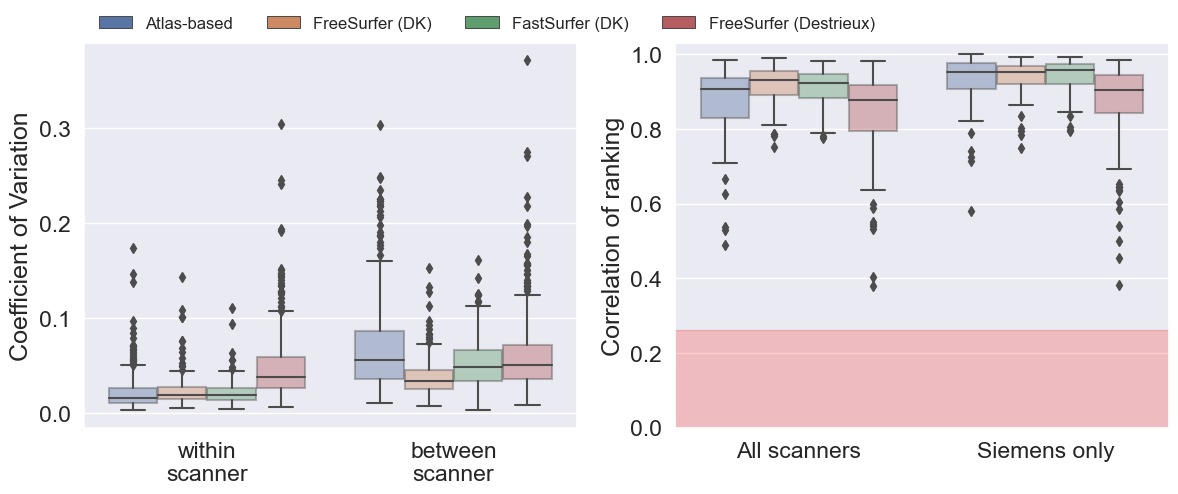

In [20]:
sns.set(font_scale = 1.5)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

order = ['Atlas-based', 'FreeSurfer (DK)', 'FastSurfer (DK)', 'FreeSurfer (Destrieux)']

# CoV
g = sns.boxplot(data=seg_cov, x='scanners', y='value', hue='Method', hue_order=order, 
                boxprops={'alpha': 0.4}, palette="deep", ax=axes[0])
axes[0].set_ylabel('Coefficient of Variation');
axes[0].set_xlabel('');
# axes[0].legend([], [], frameon=False);
# axes[0].legend(loc='upper left', fontsize=14, frameon=False);
axes[0].legend(loc='center left', frameon=False, fontsize=12, bbox_to_anchor=(0, 1.05), ncol=4)

# axes[0].set_ylim([0, 0.2])

# CorrRanking
g = sns.boxplot(data=plotdf, x='scanners', y='value', hue='Method', hue_order=order, 
                boxprops={'alpha': 0.4}, ax=axes[1])
axes[1].set_xlabel('');
axes[1].set_ylabel('Correlation of ranking');
axes[1].legend([], [], frameon=False);
# axes[1].legend(loc='lower right', fontsize=14, frameon=False);

get_null_corr(g)

plt.savefig(f'{fig_out}/free_fast_cov_corrrank.png', dpi=500, bbox_inches='tight')

In [19]:
seg_cov.groupby(['Method', 'scanners']).median()

value
Method                 scanners                  
Atlas-based            between\nscanner  0.055695
                       within\nscanner   0.015402
FastSurfer (DK)        between\nscanner  0.047767
                       within\nscanner   0.018628
FreeSurfer (DK)        between\nscanner  0.033088
                       within\nscanner   0.018910
FreeSurfer (Destrieux) between\nscanner  0.049823
                       within\nscanner   0.037100

In [20]:
plotdf.groupby(['Method', 'scanners']).median()

value
Method                 scanners              
Atlas-based            All scanners  0.905455
                       Siemens only  0.951515
FastSurfer (DK)        All scanners  0.922424
                       Siemens only  0.957576
FreeSurfer (DK)        All scanners  0.931313
                       Siemens only  0.951515
FreeSurfer (Destrieux) All scanners  0.877980
                       Siemens only  0.903030